# Exploratory Data Analysis

For data manipulation, analysis and display I will use the pandas package of Python and to find the clusters of frequently visited locations I will use the Density-based Spatial Clustering of Applications with Noise (DBSCAN) algorithm as implemented in scikit-learn. DBSCAN is the most suitable clustering algorithm for geospatial applications for several reasons. Unlike K-means and Expectation Maximization Gaussian mixture modelling it does not need to be told the number of clusters. Moreover, unlike these other two method DBSCAN can find clusters of complex shapes and it contains the concept of noise data. A disadvantage of DBSCAN is that it struggles when clusters are of different densities. DBSCAN also needs the selection of two parameters. This is often considered a disadvantage but where the data and problem is well understood, as in geospatial clustering, the ability to select these parameters can be an advantage because it allows us to set the length scale of the clustering.

DBSCAN will find clusters that correspond to locations in physical space. The remaning data points, that do not form clusters, are called noise in the parlance of the field. The clusters correspond to frequently visited locations while the noise data points correspond to locations visited only once. 

### Importing libraries

In [1]:
#Pre-loaded functions
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from mpl_toolkits.basemap import Basemap

I load the dataset into a pandas dataframe and display it.

In [2]:
df=pd.read_csv('ds_task_extract.csv',encoding='latin-1')
df.head()

C:\Users\jamil\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (25,26,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,asset_id,beacon_id,clicked,clicked_timestamp,clicked_timestamp_ms,cmid,cmname,device_latitude,device_longitude,device_speed,...,tag6_value,tag7_label,tag7_value,tag8_label,tag8_value,tag9_label,tag9_value,timestamp,timestamp_ms,uagent
0,786185535,0,0,NaN,NaN,-107,Device Config Update,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476325178,1476330000000,ios
1,786185535,0,0,NaN,NaN,-106,Has Permission For SDK,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476325184,1476330000000,ios
2,786185535,0,0,NaN,NaN,-108,Device Geofence Update,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476325184,1476330000000,ios
3,786185535,0,0,NaN,NaN,-108,Device Geofence Update,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476325697,1476330000000,ios
4,786185535,0,0,NaN,NaN,-107,Device Config Update,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1476337923,1476340000000,ios


## EDA of General Locations

I create a new dataframe with the columns I believe that are essential for accurate localization and identification.

In [3]:
data = df[['latitude', 'longitude', 'location_accuracy','timestamp', 'tag2_value', 'session']]
np.shape(data)

(380546, 6)

In [4]:
data.head()

,latitude,longitude,location_accuracy,timestamp,tag2_value,session
0,NaN,NaN,0,1476325178,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
1,NaN,NaN,0,1476325184,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2,-6.926895,107.63402,2000,1476325184,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
3,-6.926904,107.63403,2000,1476325697,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
4,NaN,NaN,0,1476337923,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545


The timestamps need to be converted to a form immediately legible to humans and set as the index of the dataframe.

In [5]:
data.index = data['timestamp']

data = data.drop('timestamp', 1)
data.columns = ['lat', 'long', 'error','time_zone', 'ID']
data.index = pd.to_datetime(data.index.values, unit='s', utc= True)
data.head()

,lat,long,error,time_zone,ID
2016-10-13 02:19:38+00:00,NaN,NaN,0,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44+00:00,NaN,NaN,0,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44+00:00,-6.926895,107.63402,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:28:17+00:00,-6.926904,107.63403,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 05:52:03+00:00,NaN,NaN,0,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545


In [6]:
data.tail()

,lat,long,error,time_zone,ID
2017-06-11 05:58:23+00:00,-6.252553,106.91418,10,Asia/Jakarta,6A355AAA3C30412EA94157537A20FD2F
2017-06-11 06:02:54+00:00,NaN,NaN,0,Asia/Jakarta,1E4CD4681D4B4F68BD08E53EC60F18E2
2017-06-11 06:02:55+00:00,-7.737197,110.42255,10,Asia/Jakarta,1E4CD4681D4B4F68BD08E53EC60F18E2
2017-06-11 06:03:53+00:00,3.600894,98.68942,1414,Asia/Jakarta,E526E9268E374926914620FF3438FB68
2017-06-11 06:20:18+00:00,NaN,NaN,0,Asia/Jakarta,2E1FB0D3074A4902BB2CFA43FD9C2FCD


Rows (or equivalently, times) not containing location information are removed.

In [7]:
data = data.dropna()
data.shape

(230920, 5)

In [8]:
data.head()

,lat,long,error,time_zone,ID
2016-10-13 02:19:44+00:00,-6.926895,107.63402,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:28:17+00:00,-6.926904,107.63403,2000,Asia/Jakarta,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 05:52:08+00:00,-2.940363,104.73718,165,Asia/Jakarta,20FF79D7396046F6AFA1786B2DB3F545
2016-10-13 06:50:41+00:00,-5.844771,112.65810,65,Asia/Jakarta,E682062F8A344B1FBE591AFEE5D1084A
2016-10-13 07:42:32+00:00,-5.849558,112.65785,65,Asia/Jakarta,E682062F8A344B1FBE591AFEE5D1084A


In [9]:
data.tail()

,lat,long,error,time_zone,ID
2017-06-11 05:41:56+00:00,-6.312669,106.758766,10,Asia/Jakarta,106AE3DE88BE446AB0F33886FF4C0A3C
2017-06-11 05:46:14+00:00,1.114995,103.974180,1414,Asia/Jakarta,5282BF2DD0204FF9AEB97FD76A23ABBE
2017-06-11 05:58:23+00:00,-6.252553,106.914180,10,Asia/Jakarta,6A355AAA3C30412EA94157537A20FD2F
2017-06-11 06:02:55+00:00,-7.737197,110.422550,10,Asia/Jakarta,1E4CD4681D4B4F68BD08E53EC60F18E2
2017-06-11 06:03:53+00:00,3.600894,98.689420,1414,Asia/Jakarta,E526E9268E374926914620FF3438FB68


To get a feeling for the data it's always a good idea to plot the data and to view it's descriptive statistics. First the statistics.

In [10]:
data.describe()

,lat,long,error
count,230920.000000,230920.000000,230920.000000
mean,-1.897891,108.981046,648.642907
std,11.455518,14.808834,1057.364526
min,-45.872494,-118.408516,0.000000
25%,-6.921259,106.779710,65.000000
50%,-6.223836,106.996712,165.000000
75%,-0.964295,112.748942,1414.000000
max,69.673680,176.253480,149000.000000


Some of the values for the uncertainty in location are enormous. Let's see how many are bigger than 10000m

In [11]:
data[data['error'] > 10000][:20]

,lat,long,error,time_zone,ID
2016-10-14 03:00:18+00:00,-7.800865,112.051140,15625,Asia/Jakarta,5274AA60764744F78CEC2A9E64D6AF8A
2016-10-15 10:10:07+00:00,-6.885526,111.974150,21862,Asia/Jakarta,823070F4C2BB4AFE98FA92F95F098CB9
2016-10-16 12:09:12+00:00,-2.295055,104.936390,12140,Asia/Jakarta,FA6013C4E5E441DA84A03581ED713685
2016-10-16 12:39:45+00:00,-2.101921,105.075645,12859,Asia/Jakarta,FA6013C4E5E441DA84A03581ED713685
2016-10-16 23:45:09+00:00,-2.094200,105.085310,13122,Asia/Jakarta,FA6013C4E5E441DA84A03581ED713685
2016-10-17 06:16:45+00:00,-0.861267,119.887450,26224,Asia/Makassar,C87F2E0497D1428899AEB03CB5947ED9
2016-10-18 07:15:10+00:00,-0.843657,119.888890,11457,Asia/Makassar,C87F2E0497D1428899AEB03CB5947ED9
2016-10-19 06:01:22+00:00,-0.847838,119.882620,14780,Asia/Makassar,C87F2E0497D1428899AEB03CB5947ED9
2016-10-19 14:39:54+00:00,3.589982,98.670120,22530,Asia/Jakarta,961071A4E90242B8ACACB3927A298B47
2016-10-22 03:12:26+00:00,25.284163,51.561478,10538,Asia/Qatar,B5C63C204F27498E86FEFC2CF9EF7049


In [12]:
data[data['error'] > 10000].count()

lat          332
long         332
error        332
time_zone    332
ID           332
dtype: int64

Location estimates with such large errors are useless in discriminating locations within a city and would in fact hinder making accurate estimates. I will deal with this issue later.

### Temporal distribution of location data

Let's examine the temporal patterns of the location activity with respect to several different criteria.

Text(0.5,1,'Location Activity as Function of Time for All Users (UTC)')

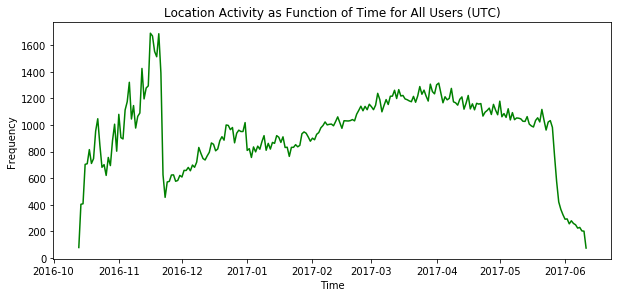

In [13]:
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = data.groupby(data.index.date).size()
plt.plot(top.index, top, 'g-')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for All Users (UTC)')

Text(0.5,1,'Monthly Location Data Distribution for All Users')

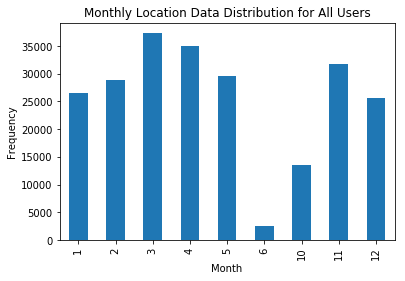

In [14]:
data.groupby(data.index.month).size().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Month')
plt.title('Monthly Location Data Distribution for All Users')

Text(0.5,1,'Daily Location Data Distribution for All Users')

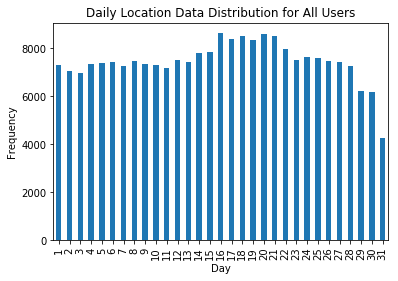

In [15]:
data.groupby(data.index.day).size().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Day')
plt.title('Daily Location Data Distribution for All Users')

Text(0.5,1,'Hourly Location Data Distribution for All Users')

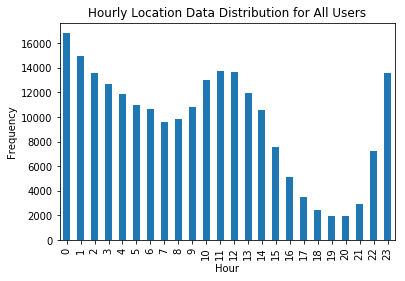

In [16]:
data.groupby(data.index.hour).size().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for All Users')

The location data were collected from October 2016 through to July 2017. Over this period data collection was somewhat irregular but all months are well represented with the exception of July. The data is distributed fairly evenly throughout the month. However, it is highly evenly distributed throughout the 24 hours of the day: this must at least partly be a reflection of human sleep and work patterns.

### Geographical distribution of location of data

It would be useful to get an idea of the geographical distribution of service users.

In [17]:
# extracting location coordinates from the dataframe and putting them into numpy arrays
lat_all = data['lat'].values  
long_all = data['long'].values

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range -118.408516 176.25348
latitude range -45.872494 69.67368
size of data (230920,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


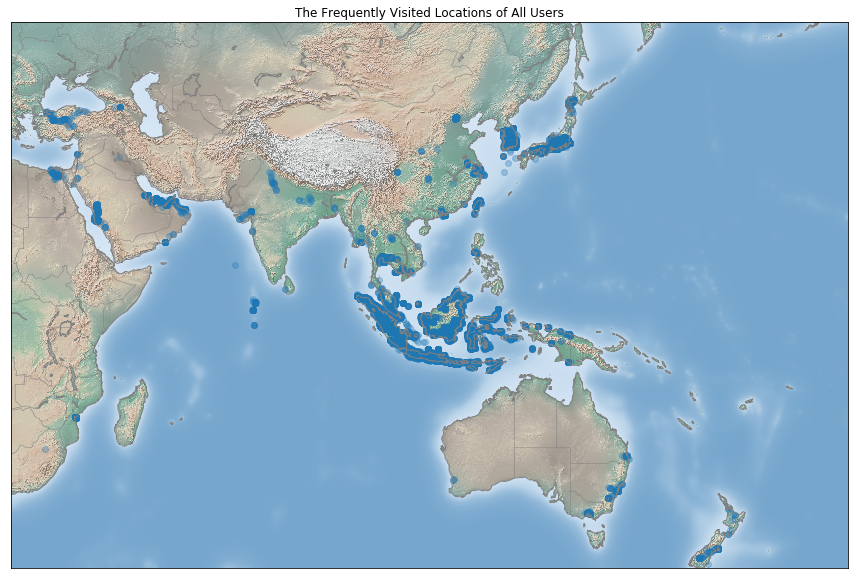

In [18]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-0.20, lon_0=112,
width=1E8, height=1.3E7)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('The Frequently Visited Locations of All Users')

print('longitude range', np.min(long_all), np.max(long_all))
print('latitude range', np.min(lat_all), np.max(lat_all))
print('size of data', np.shape(long_all))
map.scatter(long_all, lat_all, latlon=True, alpha = 0.3)

Clearly the location data shows that service users are distributed all over Asia-Pacific and beyond, towards the Near East and Australasia. The largest concentration of users by far, however, is in Indonesia.

## EDA of Device Locations

Some of the location data is labelled as 'device' data and consists of locations returned when a user leaves a geofence. I examine this device data. From the outset I observe that this location data comes with no figure for the location estimate uncertainty and therefore combining it with the general location data in a principled manner will not be straightforward.

In [19]:
devdata = df[['device_latitude', 'device_longitude', 'timestamp', 'session' ]]

In [20]:
np.shape(devdata)

(380546, 4)

In [21]:
devdata.head()

,device_latitude,device_longitude,timestamp,session
0,NaN,NaN,1476325178,E94359D6B2204A1F8CB676D9C3B8025F
1,NaN,NaN,1476325184,E94359D6B2204A1F8CB676D9C3B8025F
2,NaN,NaN,1476325184,E94359D6B2204A1F8CB676D9C3B8025F
3,NaN,NaN,1476325697,E94359D6B2204A1F8CB676D9C3B8025F
4,NaN,NaN,1476337923,20FF79D7396046F6AFA1786B2DB3F545


In [22]:
devdata.index = devdata['timestamp']
devdata = devdata.drop('timestamp', 1)
devdata.columns = ['lat', 'long', 'ID']
devdata.index = pd.to_datetime(devdata.index.values, unit='s')
devdata.head()

,lat,long,ID
2016-10-13 02:19:38,NaN,NaN,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44,NaN,NaN,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:19:44,NaN,NaN,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 02:28:17,NaN,NaN,E94359D6B2204A1F8CB676D9C3B8025F
2016-10-13 05:52:03,NaN,NaN,20FF79D7396046F6AFA1786B2DB3F545


In [23]:
#devdata.index = 

In [24]:
devdata = devdata.dropna()
devdata.head()

,lat,long,ID
2016-10-13 10:39:11,-6.879014,107.594100,59425D7CB25D4551AB6067C4FFF19418
2016-10-13 10:47:39,-6.891027,107.599507,59425D7CB25D4551AB6067C4FFF19418
2016-10-13 11:06:07,-6.913421,107.613414,59425D7CB25D4551AB6067C4FFF19418
2016-10-14 00:02:27,-6.911844,107.610106,59425D7CB25D4551AB6067C4FFF19418
2016-10-14 00:02:45,-6.913561,107.610299,59425D7CB25D4551AB6067C4FFF19418


In [25]:
devdata.describe()

,lat,long
count,11280.000000,11280.000000
mean,-4.883965,108.997849
std,3.376353,5.952181
min,-8.819895,0.000000
25%,-6.916825,106.781240
50%,-6.221382,106.883319
75%,-2.976109,112.736769
max,5.577716,140.721400


This dataset is relatively small compared to the general location data and dropping it from the analysis rather than incorporating it in an unprincipiled matter is likely to be the best course of action.

## EDA of BNI locations

I now examine the device location data labelled as BNI Blue. BNI seems to be the National Bank of Indonesia and Blue seems to refer to a taxi service popular in Indonesia. This is perhaps an advertising campaign for this taxi service.

In [26]:
BNIdata = df[['cmid', 'latitude', 'longitude', 'session']]

In [27]:
BNIBLUE = BNIdata[ BNIdata['cmid'] == 990]


In [28]:
BNIBLUE.head()

,cmid,latitude,longitude,session
55,990,-6.876557,107.59875,59425D7CB25D4551AB6067C4FFF19418
64,990,-6.887257,107.59669,59425D7CB25D4551AB6067C4FFF19418
216,990,-6.224759,106.86874,1BDBE52295F94CB4A95BFE322CAD82DC
228,990,-6.938221,107.62700,E94359D6B2204A1F8CB676D9C3B8025F
247,990,-6.908847,107.62130,E94359D6B2204A1F8CB676D9C3B8025F


In [29]:
BNIBLUE.describe()

,cmid,latitude,longitude
count,1707.0,1707.000000,1707.000000
mean,990.0,-5.153620,109.048232
std,0.0,3.243009,5.730606
min,990.0,-8.795633,95.307160
25%,990.0,-6.922669,106.790430
50%,990.0,-6.229482,106.901090
75%,990.0,-5.152037,112.720053
max,990.0,5.578020,140.706510


In [30]:
latBLUE = BNIBLUE['latitude'].values
longBLUE = BNIBLUE['longitude'].values

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 95.30716 140.70651
latitude range -8.795633 5.57802
size of data (1707,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


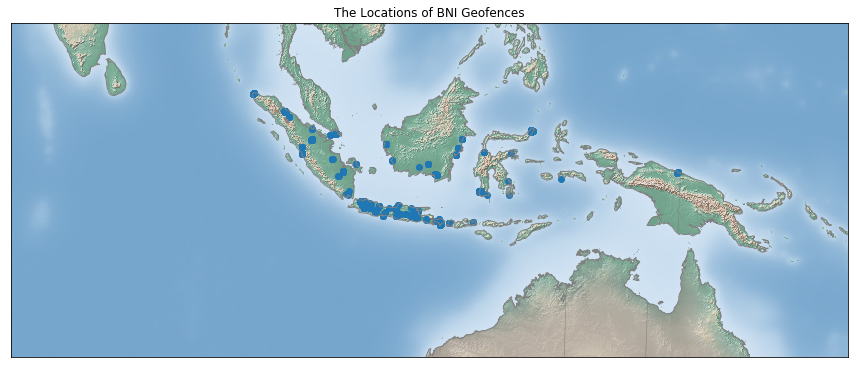

In [31]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')

plt.title('The Locations of BNI Geofences')
print('longitude range', np.min(longBLUE), np.max(longBLUE))
print('latitude range', np.min(latBLUE), np.max(latBLUE))
print('size of data', np.shape(longBLUE))
map.scatter(longBLUE, latBLUE, latlon=True)

The locations in this dataset are restricted to Indonesia but are quite evenly distributed over the whole country.

## Case Studies of Three Service Users

The ID column labels location data from different service users or individuals. In order to understand location patterns better I will investigate the data from the three most active service users in detail. First I see how many different users there are and how much data is available for them.

In [32]:
data['ID'].value_counts() # value_counts() counts unique occurences

7935F740476346B6BD36672576F001D5    897
283FCF1B13BC4D9C947AD983621D1EB1    885
020617FA36714A919789E2CEDF062BB6    792
693F438096B34926B05C76EC75366AD6    651
2F9D08E972934BAAA3702A67B605AA29    647
464865F5521D4D7B9D09D7B0F3052FC4    616
6B3837764A6E446A89A24CA18BCE882A    607
14E2BF3252CB4B4282C1F4B556AAC4E4    577
7C6405D36BAA4EA2A601A0F4462DBE71    525
F5439A2F97B6419D83569E21455DC020    497
533F0016115A45C788E6E73AA829CE80    494
E40C6352EDCA467EAD23F4873BAB6CB4    494
80A500967E2C445FBFD726851B022984    472
7F201A349BEA449F998A1D8115C342C4    463
2622ADFA67664E7FA12F914AD0909BE8    457
5F39E81A63B346D5ADC4C830BF536D0A    457
AD1427C4555A4BE1B33AC56ACA24DFF8    450
FA76F0D6FE1A4349BD2EA94B6B7AB366    446
E836DB1374AA4B53B745BD951D0C8476    405
5F5218121AD84DF8BAD8E2FAAD767ED3    396
7DAF1F766424490CAF1C1329F25CD954    390
9E462EFCCD8045D39AC966E26BF800AB    374
98E8059807624C39866B466AD5E4F938    371
2B72A3353C2D48D68624262B62A228D4    370
D09E1C8C8789470BA2660448E1088E82    363


The dataset consists of location data from 1385 users. I proceed to  explore the data from the top three users in detail. 

## Profile of User One

I extract the data from the top most user and put it into a pandas dataframe for further processing. First, the device data.

In [34]:
ID1dev = devdata[ devdata['ID'] == '7935F740476346B6BD36672576F001D5']

In [35]:
ID1dev.head()

,lat,long,ID
2016-12-05 03:02:20,1.486551,124.851796,7935F740476346B6BD36672576F001D5
2016-12-05 10:04:30,1.478341,124.834355,7935F740476346B6BD36672576F001D5
2016-12-05 10:07:00,1.475366,124.833545,7935F740476346B6BD36672576F001D5
2016-12-05 11:54:25,1.483612,124.836416,7935F740476346B6BD36672576F001D5
2016-12-05 12:00:15,1.487344,124.842000,7935F740476346B6BD36672576F001D5


In [36]:
np.shape(ID1dev)

(42, 3)

With only 42 points this is a small dataset compared with the general locations dataset. I will not incorporate this into the analysis. Out of curiosity I plot the device locations to examine their geographic distribution.

In [37]:
latdev = ID1dev['lat'].values
longdev = ID1dev['long'].values

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 106.783035 124.851796
latitude range -6.17631 1.49357
size of data (42,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


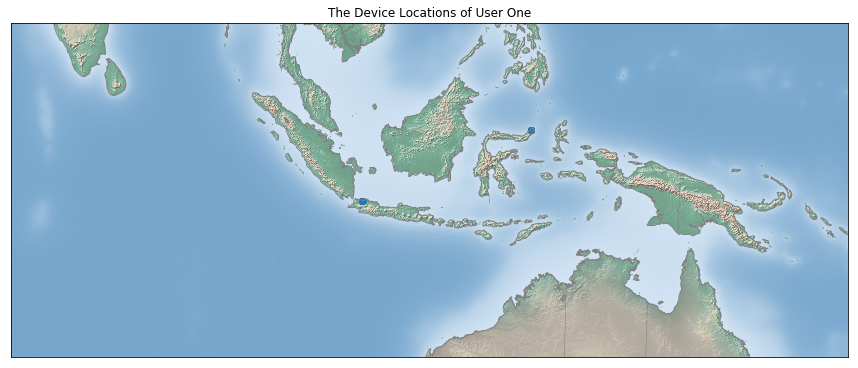

In [38]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')

plt.title('The Device Locations of User One')
print('longitude range', np.min(longdev), np.max(longdev))
print('latitude range', np.min(latdev), np.max(latdev))
print('size of data', np.shape(longdev))
map.scatter(longdev, latdev, latlon=True)

### The General Locations of User One

Now I examine the general locations dataset for user one.

In [39]:
ID1 = data[ data['ID'] == '7935F740476346B6BD36672576F001D5']

In [40]:
ID1.head()

,lat,long,error,time_zone,ID
2016-12-02 06:49:44+00:00,1.490873,124.86219,165,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 02:14:33+00:00,1.488766,124.84024,249,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 03:02:20+00:00,1.491944,124.84509,165,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 07:50:51+00:00,1.493723,124.86465,149,Asia/Makassar,7935F740476346B6BD36672576F001D5
2016-12-05 09:54:47+00:00,1.490844,124.84582,65,Asia/Makassar,7935F740476346B6BD36672576F001D5


In [41]:
ID1.tail()

,lat,long,error,time_zone,ID
2017-05-26 13:09:32+00:00,-6.176600,106.790600,104,Asia/Jakarta,7935F740476346B6BD36672576F001D5
2017-05-26 13:47:03+00:00,-6.176947,106.790380,65,Asia/Jakarta,7935F740476346B6BD36672576F001D5
2017-05-26 13:52:37+00:00,-6.177041,106.790520,65,Asia/Jakarta,7935F740476346B6BD36672576F001D5
2017-05-26 15:01:04+00:00,-6.176772,106.790950,95,Asia/Jakarta,7935F740476346B6BD36672576F001D5
2017-05-27 05:29:37+00:00,-6.176430,106.790306,65,Asia/Jakarta,7935F740476346B6BD36672576F001D5


I can now drop the ID column from user one's dataframe to make it more compact.

In [42]:
ID1 = ID1.drop('ID', 1)

In [43]:
ID1.describe()

,lat,long,error
count,897.000000,897.000000,897.000000
mean,-5.365654,108.564082,133.325530
std,2.355842,6.618575,384.848595
min,-6.197942,0.000000,0.000000
25%,-6.176940,106.790320,65.000000
50%,-6.176536,106.790560,87.000000
75%,-6.176095,106.791046,165.000000
max,1.540755,124.920690,10678.000000


The descriptive statistics show that the uncertainty in location estimate for some data points is huge.

Text(0.5,1,'Location Uncertainty Distribution for User One')

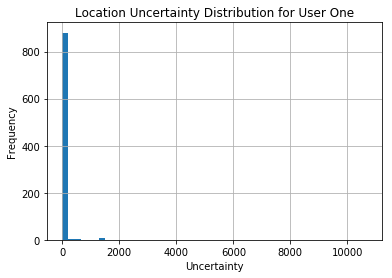

In [44]:
ID1.hist(column ='error', bins = 50)
plt.ylabel('Frequency')
plt.xlabel('Uncertainty')
plt.title('Location Uncertainty Distribution for User One')

I expect the cluster seperation for users to be of the order of hundreds of metres. It therefore makes little sense to retain data whose location estimates are greater than the distance between clusters. Setting a threshold of 300 meteres I remove all data whose location uncertainty is greater.

In [45]:
ID1[ID1['error'] > 300].count()

lat          14
long         14
error        14
time_zone    14
dtype: int64

In [46]:
ID1 = ID1[ID1['error'] < 300]
ID1.describe()

,lat,long,error
count,883.000000,883.000000,883.000000
mean,-5.405109,108.469192,104.884485
std,2.304327,6.531068,51.656793
min,-6.197942,0.000000,0.000000
25%,-6.176944,106.790320,65.000000
50%,-6.176549,106.790560,86.000000
75%,-6.176139,106.791018,165.000000
max,1.494193,124.869250,278.000000


Observe that removing the erroneous data points has signifiantly shifted the mean of the error and dramatically reduced its variance.

In [47]:
ID1.head()

,lat,long,error,time_zone
2016-12-02 06:49:44+00:00,1.490873,124.86219,165,Asia/Makassar
2016-12-05 02:14:33+00:00,1.488766,124.84024,249,Asia/Makassar
2016-12-05 03:02:20+00:00,1.491944,124.84509,165,Asia/Makassar
2016-12-05 07:50:51+00:00,1.493723,124.86465,149,Asia/Makassar
2016-12-05 09:54:47+00:00,1.490844,124.84582,65,Asia/Makassar


In [48]:
latone = ID1['lat'].values
longone = ID1['long'].values
errorone = ID1['error'].values
np.shape(errorone)

(883,)

Plotting a histogram of error values to examine their distribution:

Text(0.5,1,'Location Uncertainty Distribution for User One')

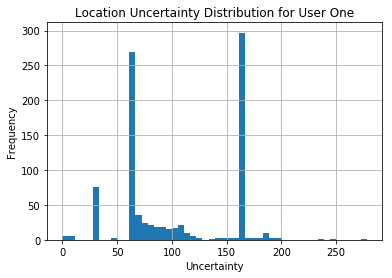

In [49]:
ID1.hist(column ='error', bins = 50)
plt.ylabel('Frequency')
plt.xlabel('Uncertainty')
plt.title('Location Uncertainty Distribution for User One')

In order to see where user one is situated I plot his locations on a map.

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 0.0 124.86925
latitude range -6.197942 1.494193
size of data (883,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


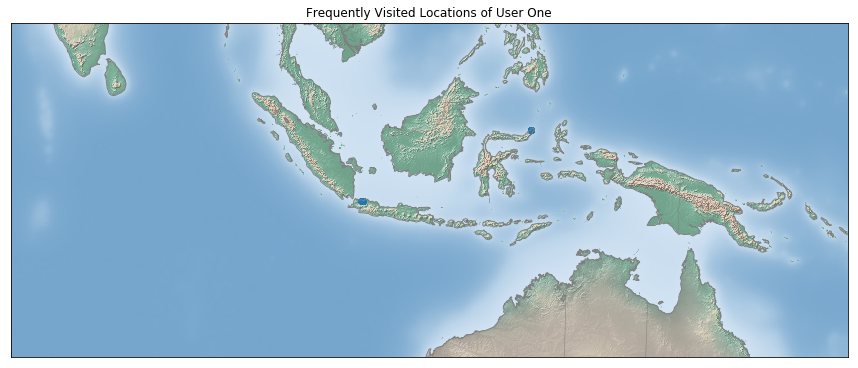

In [50]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('Frequently Visited Locations of User One')

print('longitude range', np.min(longone), np.max(longone))
print('latitude range', np.min(latone), np.max(latone))
print('size of data', np.shape(longone))
map.scatter(longone, latone, latlon=True)

This user spends his time at two locations quite far from each other. Let's plot the latitude and longitude of this user's locations against time to track his movements.

Text(0.5,1,'Time Evolution of Location Coordinates of User One')

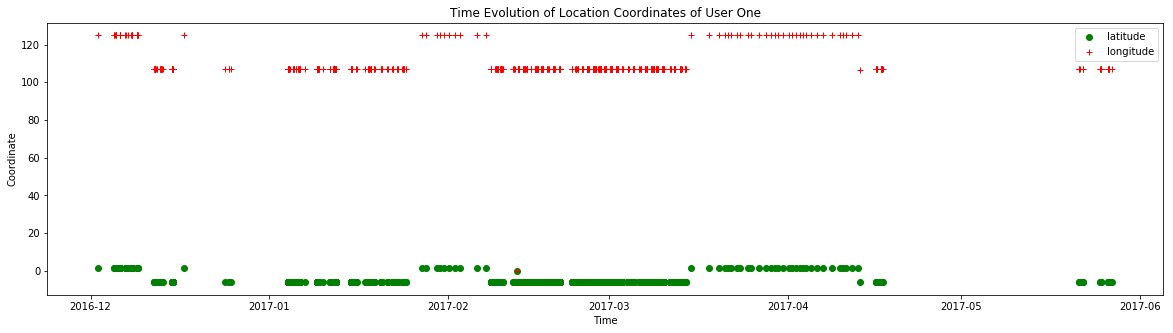

In [51]:
fig = plt.figure(figsize=[20,5])
plt.plot (ID1.index, latone, 'go', label ='latitude')
plt.plot (ID1.index, longone, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User One')

I plot the locations now with the errors associated with each point represented by the area of a circle, i.e. the larger the area the larger the uncertainty.

Text(0,0.5,'latitude')

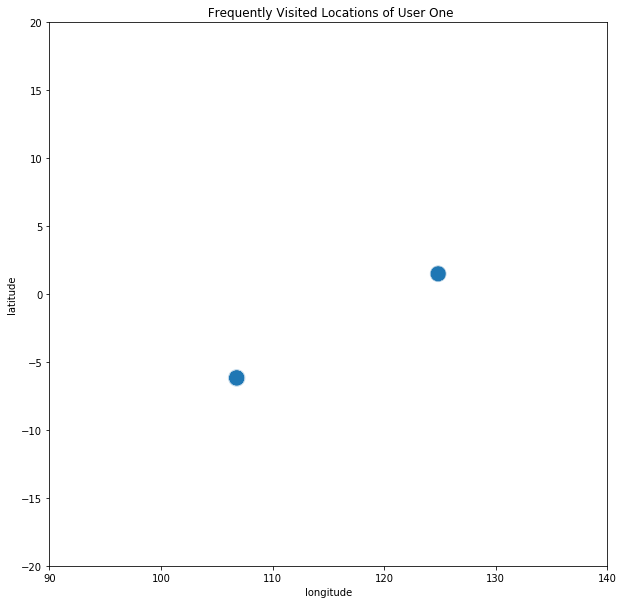

In [52]:
fig = plt.figure(figsize=(10,10))
plt.scatter(longone, latone, s= errorone, alpha = 0.2)
plt.ylim(-20,20)
plt.xlim(90,140)
plt.title(' Frequently Visited Locations of User One')
plt.xlabel('longitude')
plt.ylabel('latitude')

Checking these coordinates on google maps the western location corresponds to Jakarta, Indonesia's capital and largest city, while the eastern location is the small city of Manado in North Sulawesi province. User one shifts between both places. He spends extended lengths of time at both places but more of his time is spent in Jakarta.

### Clustering with DBSCAN for User One

#### Some DBSCAN Theory

Values for two parameters must be selected when using the DBSCAN algorithm. The epsilon parameter I set to 0.001 degrees. Since at the equator an angle of 1 degree corresponds to a distance of around 111km this value of epsilon sets a length scale of around 111m. The Minpts parameter I set to 3 because of the relatively small size of the dataset.

In [53]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID1sorted = ID1
coordinates = ID1sorted.as_matrix(columns=[ 'long', 'lat', 'error'])

In [54]:
db = DBSCAN(eps=0.001, min_samples=3 ).fit(coordinates[:,:2])
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

In [55]:
# calculate the number of clusters in labels, ignoring noise (which is labeled -1) if present
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print('The number of clusters foud is', num_clusters)

The number of clusters foud is 11


In [56]:
def plot_clusters(coordinates, unique_labels, num_clusters, cluster_labels, xrange, yrange):
    
    """ Function to display the clusters found by DBSCAN within a coordinate range
    """
    fig, ax = plt.subplots(figsize=[10,10])
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    # for each cluster label and color, plot the cluster's points
    for cluster_label, color in zip(unique_labels, colors):
    
        size = 150
        if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
            color = 'gray'
            size = 30
    
        # plot the points that match the current cluster label
        x_coords = coordinates[cluster_labels==cluster_label][:,0]
        y_coords = coordinates[cluster_labels==cluster_label][:,1]
        error_rad =coordinates[cluster_labels==cluster_label][:,2]
        ax.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=error_rad, alpha=0.5)

    
    ax.set_title('Number of clusters: {}'.format(num_clusters))
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    plt.ylim(yrange)
    plt.xlim(xrange)

Clustering after DBSCAN. 

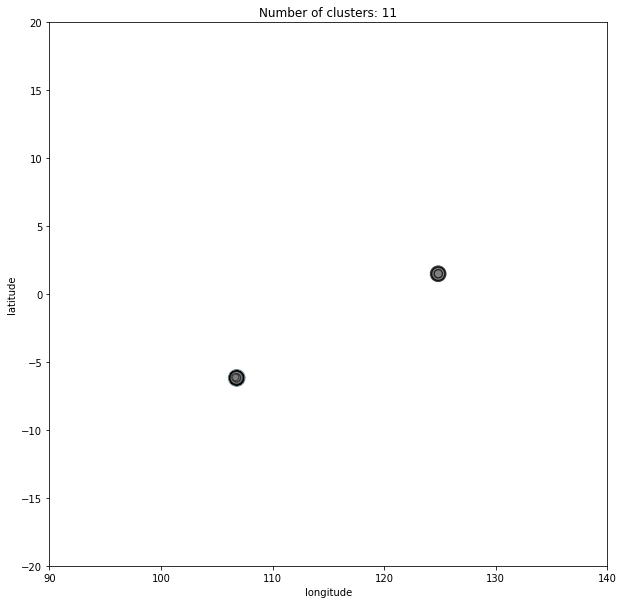

In [57]:
ylims = (-20,20)
xlims = (90,140) 

plot_clusters(coordinates, unique_labels, num_clusters, cluster_labels, xlims, ylims)

On this scale we again observe two sets of clusters at geographically seperate locations. To observe more detail let's focus in on each of them.

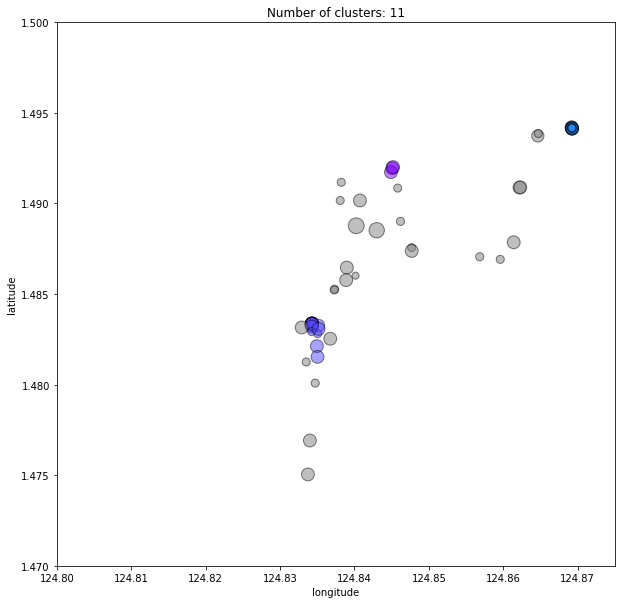

In [58]:
ylims = (1.47, 1.50)
xlims = (124.8, 124.875) 

plot_clusters(coordinates, unique_labels, num_clusters, cluster_labels, xlims, ylims)

Not much happening here. I now focus in on the other location.

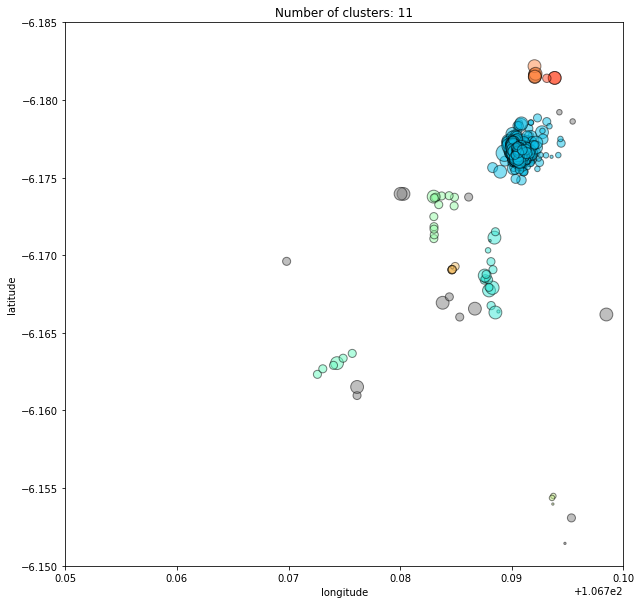

In [59]:
ylims = (-6.15,-6.185)
xlims = (106.75, 106.8) 

plot_clusters(coordinates, unique_labels, num_clusters, cluster_labels, xlims, ylims)

Much  more activity here. Clearly most of the data is from Jakarta. I examine the temporal statistics of the three largest clusters, two in Jakarta and one in Manado.

## Analysis of Frequently Visited Locations for  User One

In [60]:
print(np.shape(cluster_labels))

(883,)


Determining the number of clusters, their labels and the number of data points in each.

In [61]:
un = np.unique(cluster_labels, return_counts = True)

In [62]:
print(un)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64), array([ 47,   3,  24,  34, 720,  17,   6,  14,   3,   6,   6,   3], dtype=int64))


There are eleven clusters and by far the majority of the data is in one location. I investigate this location in more detail. In the following three graphs I plot the number of visits to this location versus the days of week, the hours of a day and against time. -1 indicates a noise point and this data set has quite a large number of noise points.

**Most Active Location of User One**

In [63]:
zeroInd = cluster_labels == 3

Zero = coordinates[zeroInd]
Zero[:5,:3]

array([[ 106.78829 ,   -6.175638,  100.      ],
       [ 106.78995 ,   -6.175937,   50.      ],
       [ 106.7894  ,   -6.176057,  100.      ],
       [ 106.79041 ,   -6.17691 ,   67.      ],
       [ 106.79079 ,   -6.177357,   93.      ]])

In [64]:
Zerodate = ID1sorted[zeroInd]
Zerodate.head()

,lat,long,error,time_zone
2016-12-12 02:05:47+00:00,-6.175638,106.78829,100,Asia/Jakarta
2016-12-12 02:15:06+00:00,-6.175937,106.78995,50,Asia/Jakarta
2016-12-12 02:17:13+00:00,-6.176057,106.78940,100,Asia/Jakarta
2016-12-12 02:43:37+00:00,-6.176910,106.79041,67,Asia/Jakarta
2016-12-12 02:47:07+00:00,-6.177357,106.79079,93,Asia/Jakarta


I convert the time from UTC to local time.

In [65]:
Zerodate.index = Zerodate.index.tz_convert('Asia/Jakarta')
Zerodate.head()

,lat,long,error,time_zone
2016-12-12 09:05:47+07:00,-6.175638,106.78829,100,Asia/Jakarta
2016-12-12 09:15:06+07:00,-6.175937,106.78995,50,Asia/Jakarta
2016-12-12 09:17:13+07:00,-6.176057,106.78940,100,Asia/Jakarta
2016-12-12 09:43:37+07:00,-6.176910,106.79041,67,Asia/Jakarta
2016-12-12 09:47:07+07:00,-6.177357,106.79079,93,Asia/Jakarta


Text(0.5,1,'Daily Location Data Distribution for User One')

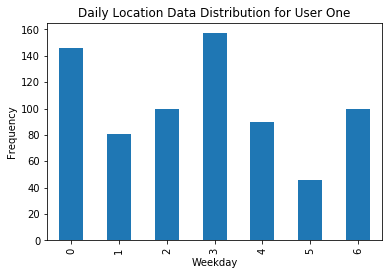

In [66]:
Zerodate.groupby(Zerodate.index.weekday)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User One')

Text(0.5,1,'Hourly Location Data Distribution for User One')

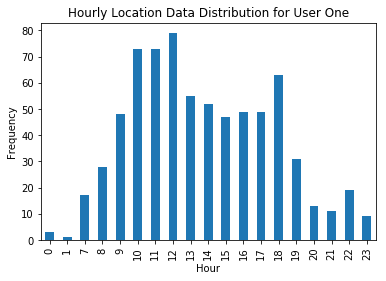

In [67]:
Zerodate.groupby(Zerodate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User One')

Text(0.5,1,'Location Activity as Function of Time for User One')

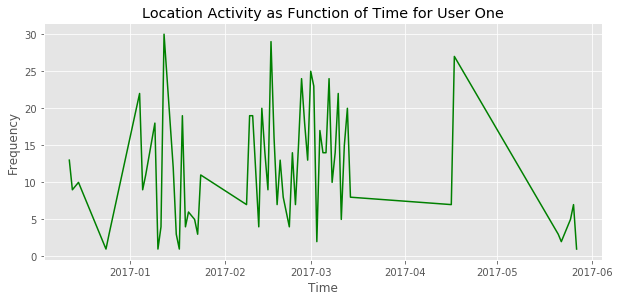

In [68]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Zerodate.groupby(Zerodate.index.date).size()
plt.plot(top.index, top, 'g-')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User One')

**Second Most Active Location of User One**

I now present the same three graphs for the second most frequently visited location which is in Manado.

In [69]:
oneInd = cluster_labels ==2
One = coordinates[oneInd]
One[:5,:3]

array([[ 124.869225,    1.494154,   65.      ],
       [ 124.86924 ,    1.494141,   65.      ],
       [ 124.86923 ,    1.494149,   65.      ],
       [ 124.86923 ,    1.49415 ,   65.      ],
       [ 124.86923 ,    1.494151,   65.      ]])

In [70]:
Onedate = ID1sorted[oneInd]
Onedate.head()

,lat,long,error,time_zone
2016-12-07 12:39:21+00:00,1.494154,124.869225,65,Asia/Makassar
2016-12-17 06:54:56+00:00,1.494141,124.869240,65,Asia/Makassar
2017-01-27 10:34:41+00:00,1.494149,124.869230,65,Asia/Makassar
2017-01-28 03:08:07+00:00,1.494150,124.869230,65,Asia/Makassar
2017-01-30 01:26:51+00:00,1.494151,124.869230,65,Asia/Makassar


In [71]:
Onedate = Onedate.tz_convert('Asia/Makassar')
Onedate.head()

,lat,long,error,time_zone
2016-12-07 20:39:21+08:00,1.494154,124.869225,65,Asia/Makassar
2016-12-17 14:54:56+08:00,1.494141,124.869240,65,Asia/Makassar
2017-01-27 18:34:41+08:00,1.494149,124.869230,65,Asia/Makassar
2017-01-28 11:08:07+08:00,1.494150,124.869230,65,Asia/Makassar
2017-01-30 09:26:51+08:00,1.494151,124.869230,65,Asia/Makassar


Text(0.5,1,'Daily Location Data Distribution for User One')

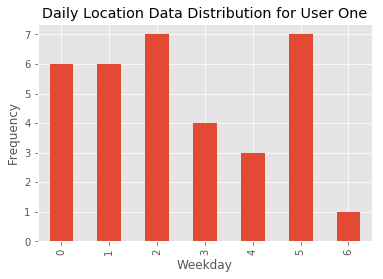

In [72]:
Onedate.groupby(Onedate.index.weekday)['lat'].count().plot(kind="bar", xticks = (np.arange(7)))
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User One')

Text(0.5,1,'Hourly Location Data Distribution for User One')

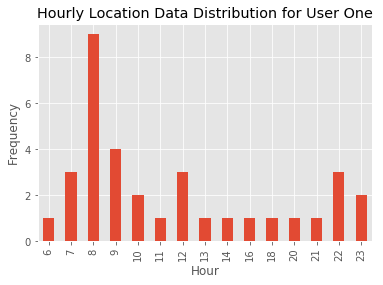

In [73]:
Onedate.groupby(Onedate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User One')

Text(0.5,1,'Location Activity as Function of time for User One')

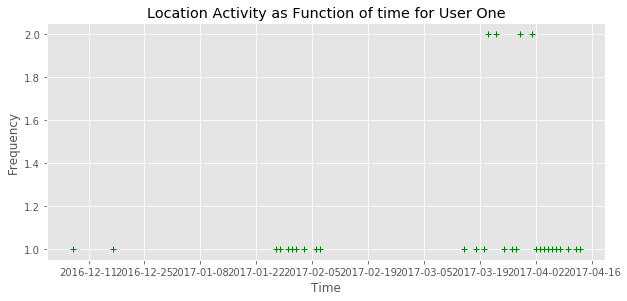

In [74]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Onedate.groupby(Onedate.index.date).size()
plt.plot(top.index, top, 'g+')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of time for User One')

**Third Most Active Location of User One**

Let's examine the third most visited location, also in Manado:

In [75]:
threeInd = cluster_labels ==1
Three = coordinates[threeInd]
Three[:5,:3]

array([[ 124.83495 ,    1.482122,  165.      ],
       [ 124.8343  ,    1.483378,  165.      ],
       [ 124.83428 ,    1.48335 ,  165.      ],
       [ 124.83428 ,    1.483356,  165.      ],
       [ 124.83427 ,    1.48333 ,  165.      ]])

In [76]:
Threedate = ID1sorted[threeInd]
Threedate.head()

,lat,long,error,time_zone
2016-12-06 01:57:57+00:00,1.482122,124.83495,165,Asia/Makassar
2016-12-06 02:01:54+00:00,1.483378,124.83430,165,Asia/Makassar
2016-12-06 02:03:27+00:00,1.483350,124.83428,165,Asia/Makassar
2016-12-06 02:15:20+00:00,1.483356,124.83428,165,Asia/Makassar
2016-12-06 02:19:31+00:00,1.483330,124.83427,165,Asia/Makassar


In [141]:
Threedate = Threedate.tz_convert('Asia/Makassar')
Threedate.head()

,lat,long,error,time_zone
2016-12-06 09:57:57+08:00,1.482122,124.83495,165,Asia/Makassar
2016-12-06 10:01:54+08:00,1.483378,124.83430,165,Asia/Makassar
2016-12-06 10:03:27+08:00,1.483350,124.83428,165,Asia/Makassar
2016-12-06 10:15:20+08:00,1.483356,124.83428,165,Asia/Makassar
2016-12-06 10:19:31+08:00,1.483330,124.83427,165,Asia/Makassar


Text(0.5,1,'Daily Location Data Distribution for User One')

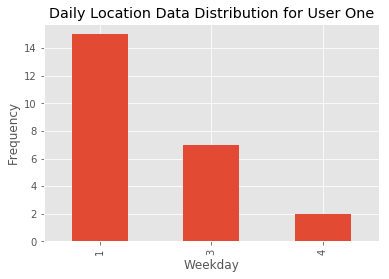

In [77]:
ran = np.arange(24)
Threedate.groupby(Threedate.index.weekday)['lat'].count().plot(kind="bar", xticks = (np.arange(7)))
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User One')

Text(0.5,1,'Hourly Location Data Distribution for User One')

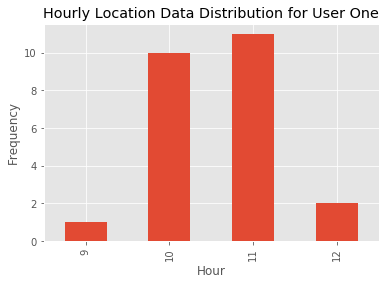

In [78]:
Threedate.groupby(Threedate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User One')

Text(0.5,1,'Location Activity as Function of Time for User One')

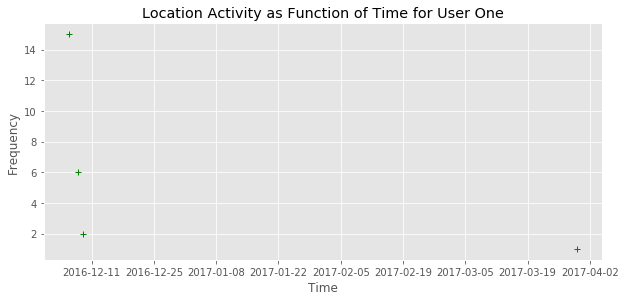

In [79]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Threedate.groupby(Threedate.index.date).size()
plt.plot(top.index, top, 'g+')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User One')

This location is also in Manado and infrequently visited by user one.

**Discussion on User One**

This user's temporal location patterns were quite surprising. The most frequently visited location was in Jakarta and I believe this is where he is living most of the time.  Location were recieved  consistently over a week, however, there were no data from the evenings. He was in Manado less frequently but his daily and weekly activity patterns there were similiar to those in Jakarta.This may reflect work or study patterns. His most frequently visited location cooincided with the university area of Jakarta. I would guess he is a student in Jakarta but whose hometown is Manado, which he occasionally visits.

## Profile of User Two

I repeat the above analysis for user two.

In [80]:
ID2 = data[data['ID'] == '020617FA36714A919789E2CEDF062BB6']
ID2.head()

,lat,long,error,time_zone,ID
2016-12-30 11:25:10+00:00,1.122040,104.02480,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-30 15:03:35+00:00,1.125491,104.02973,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-30 23:51:52+00:00,1.121591,104.02548,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-31 11:43:28+00:00,1.128759,104.03133,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2016-12-31 11:57:59+00:00,1.128759,104.03133,10,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6


In [81]:
ID2.tail()

,lat,long,error,time_zone,ID
2017-05-26 04:45:57+00:00,1.129084,104.031430,30,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2017-05-26 10:50:51+00:00,1.128714,104.031400,30,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2017-05-26 13:17:06+00:00,1.131213,104.016810,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2017-05-26 15:21:50+00:00,1.128706,104.031845,30,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6
2017-05-27 05:32:05+00:00,1.149432,104.024956,1414,Asia/Jakarta,020617FA36714A919789E2CEDF062BB6


In [82]:
ID2 = ID2.drop('ID', 1)
ID2.head()

,lat,long,error,time_zone
2016-12-30 11:25:10+00:00,1.122040,104.02480,1414,Asia/Jakarta
2016-12-30 15:03:35+00:00,1.125491,104.02973,10,Asia/Jakarta
2016-12-30 23:51:52+00:00,1.121591,104.02548,1414,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.03133,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.03133,10,Asia/Jakarta


In [83]:
ID2.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,1.127744,104.028999,118.405303
std,0.009882,0.009625,206.103993
min,1.041687,103.936910,5.000000
25%,1.125324,104.028404,65.000000
50%,1.127978,104.031128,65.000000
75%,1.128750,104.031720,165.000000
max,1.158209,104.056830,1414.000000


In [84]:
lat2 = ID2['lat'].values
long2 = ID2['long'].values
error2 = ID2['error'].values
np.shape(lat2)

(792,)

Text(0.5,1,'Time Evolution of Location Coordinates of User Two')

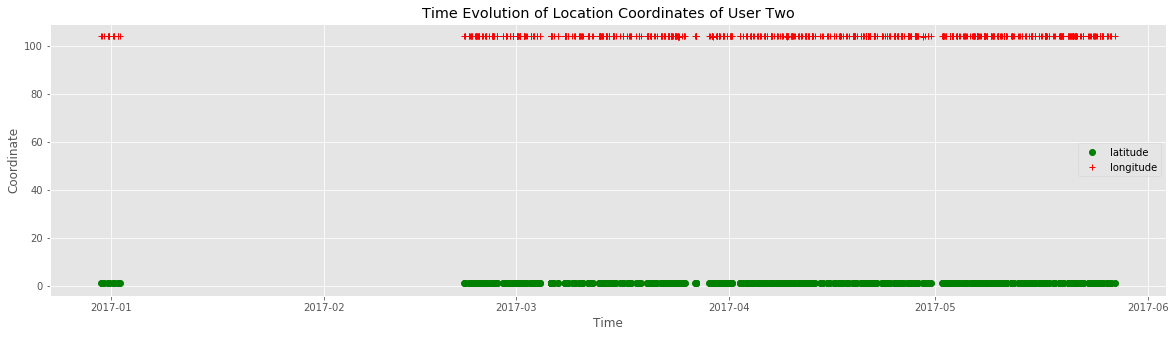

In [85]:
fig = plt.figure(figsize=[20,5])
plt.plot(ID2.index, lat2, 'go', label= 'latitude')
plt.plot (ID2.index, long2, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User Two')

There is a large gap in user two's activity between January 2017 and mid February 2017. User two lived in the island Batam and seems to spend all his time there.

C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 103.93691 104.05683
latitude range 1.041687 1.158209
size of data (792,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


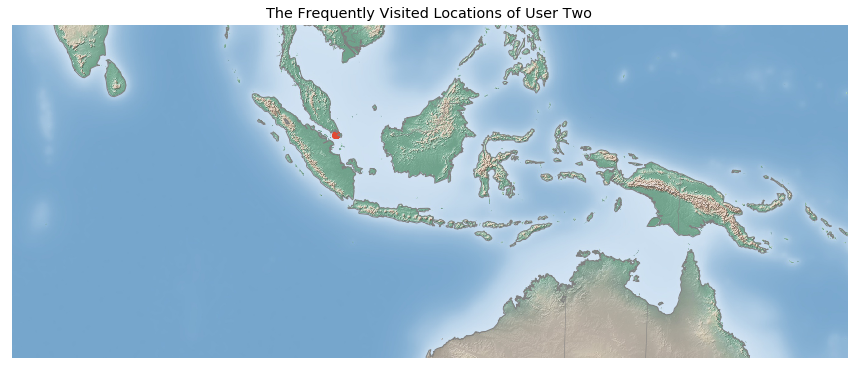

In [86]:
fig = plt.figure(figsize=(15, 15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('The Frequently Visited Locations of User Two')

print('longitude range', np.min(long2), np.max(long2))
print('latitude range', np.min(lat2), np.max(lat2))
print('size of data', np.shape(long2))
map.scatter(long2, lat2, latlon=True)

In [87]:
np.shape(ID2)

(792, 4)

In [88]:
ID2.tail()

,lat,long,error,time_zone
2017-05-26 04:45:57+00:00,1.129084,104.031430,30,Asia/Jakarta
2017-05-26 10:50:51+00:00,1.128714,104.031400,30,Asia/Jakarta
2017-05-26 13:17:06+00:00,1.131213,104.016810,1414,Asia/Jakarta
2017-05-26 15:21:50+00:00,1.128706,104.031845,30,Asia/Jakarta
2017-05-27 05:32:05+00:00,1.149432,104.024956,1414,Asia/Jakarta


In [89]:
ID2.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,1.127744,104.028999,118.405303
std,0.009882,0.009625,206.103993
min,1.041687,103.936910,5.000000
25%,1.125324,104.028404,65.000000
50%,1.127978,104.031128,65.000000
75%,1.128750,104.031720,165.000000
max,1.158209,104.056830,1414.000000


I remove all data with location errors greater than 300m.

In [90]:
ID2[ID2['error'] < 300].count()

lat          773
long         773
error        773
time_zone    773
dtype: int64

In [91]:
ID2 = ID2[ID2['error'] < 300]
ID2.describe()

,lat,long,error
count,773.000000,773.000000,773.000000
mean,1.127637,104.028979,87.218629
std,0.009852,0.009669,51.102306
min,1.041687,103.936910,5.000000
25%,1.125326,104.028440,65.000000
50%,1.127967,104.031150,65.000000
75%,1.128740,104.031720,165.000000
max,1.154340,104.056830,262.000000


We see another large reduction in the mean and the variance of the error.

In [92]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID2sorted = ID2 
coordinates2 = ID2sorted.as_matrix(columns=[ 'long', 'lat', 'error'])


In [93]:
ID2sorted.head()

,lat,long,error,time_zone
2016-12-30 15:03:35+00:00,1.125491,104.029730,10,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 14:25:38+00:00,1.102898,104.037155,165,Asia/Jakarta
2016-12-31 14:37:55+00:00,1.125444,104.029526,165,Asia/Jakarta


I now focus in on Batam in order to better view the data distribution.

Text(0,0.5,'latitude')

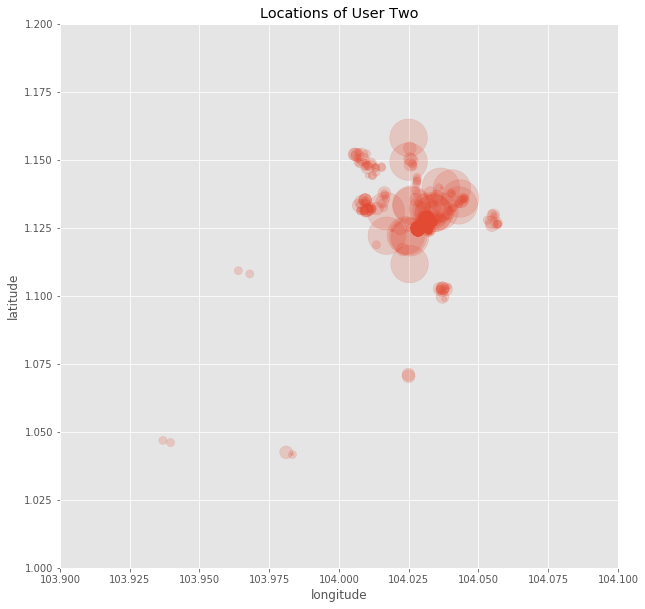

In [94]:
fig = plt.figure(figsize=(10,10))
plt.scatter(long2, lat2, s= error2, alpha = 0.2)
plt.ylim(1, 1.2)
plt.xlim(103.9, 104.1)
plt.title('Locations of User Two')
plt.xlabel('longitude')
plt.ylabel('latitude')

## DBSCAN Clustering for User Two

In [95]:
db2 = DBSCAN(eps=0.005, min_samples=3).fit(coordinates2[:,:2])
cluster_labels2 = db2.labels_
unique_labels2 = set(cluster_labels2)

In [96]:
num_clusters2 = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
num_clusters2
print('The number of clusters is', num_clusters2)

The number of clusters is 6


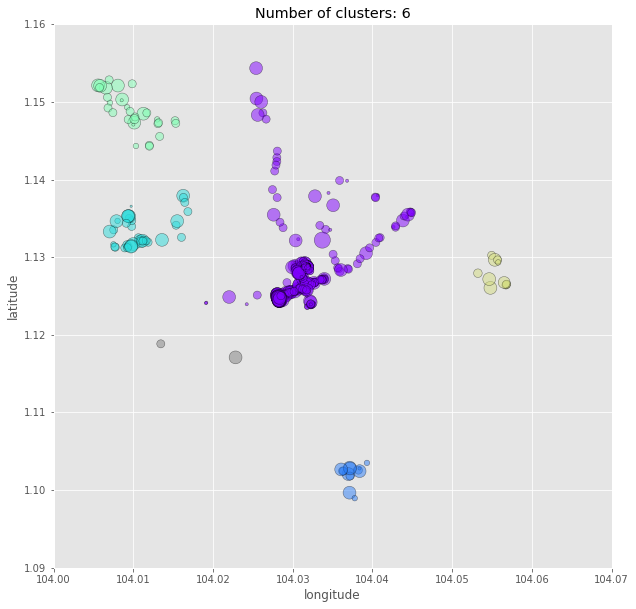

In [97]:
ylims = (1.09, 1.16)
xlims = (104, 104.07)

plot_clusters(coordinates2, unique_labels2, num_clusters2, cluster_labels2, xlims, ylims)

## Analysis of Frequently Visited Locations for User Two

**Most Active Location of User Two**

Print the clusters found and their sizes:

In [98]:
test2 = cluster_labels2 == 0
un2 = np.unique(cluster_labels2, return_counts = True)
print(un2)

(array([-1,  0,  1,  2,  3,  4,  5], dtype=int64), array([  8, 669,  13,  38,  31,  11,   3], dtype=int64))


I investigate the largest cluster in more detail.

In [99]:
zeroInd = cluster_labels2 == 0
Zero = coordinates2[zeroInd]
np.shape(Zero)
Zero = coordinates2[zeroInd]
np.shape(Zero)
Zero[:5,:3]

array([[ 104.02973 ,    1.125491,   10.      ],
       [ 104.03133 ,    1.128759,   10.      ],
       [ 104.03133 ,    1.128759,   10.      ],
       [ 104.029526,    1.125444,  165.      ],
       [ 104.03186 ,    1.126562,   65.      ]])

In [100]:
Zerodate = ID2[zeroInd]
Zerodate.head()

,lat,long,error,time_zone
2016-12-30 15:03:35+00:00,1.125491,104.029730,10,Asia/Jakarta
2016-12-31 11:43:28+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 11:57:59+00:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 14:37:55+00:00,1.125444,104.029526,165,Asia/Jakarta
2016-12-31 14:52:33+00:00,1.126562,104.031860,65,Asia/Jakarta


In [101]:
Zerodate.index = Zerodate.index.tz_convert('Asia/Jakarta')
Zerodate.head()

,lat,long,error,time_zone
2016-12-30 22:03:35+07:00,1.125491,104.029730,10,Asia/Jakarta
2016-12-31 18:43:28+07:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 18:57:59+07:00,1.128759,104.031330,10,Asia/Jakarta
2016-12-31 21:37:55+07:00,1.125444,104.029526,165,Asia/Jakarta
2016-12-31 21:52:33+07:00,1.126562,104.031860,65,Asia/Jakarta


Text(0.5,1,'Daily Location Data Distribution for User Two')

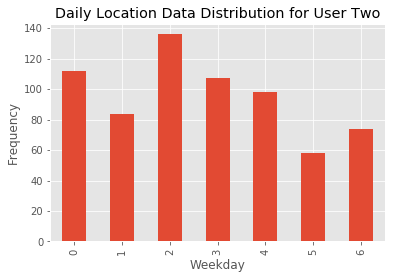

In [102]:
Zerodate.groupby(Zerodate.index.weekday)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User Two')

Text(0.5,1,'Hourly Location Data Distribution for User Two')

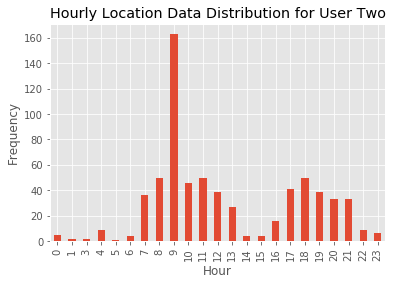

In [103]:
Zerodate.groupby(Zerodate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User Two')

Text(0.5,1,'Location Activity as Function of Time for User Two')

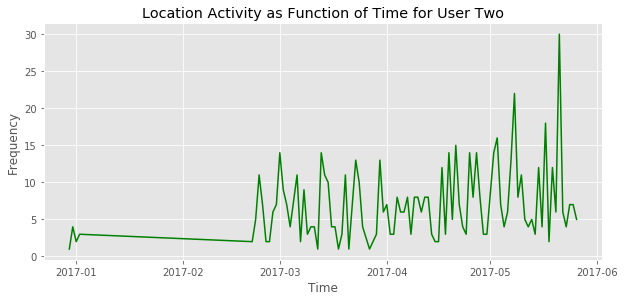

In [104]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Zerodate.groupby(Zerodate.index.date).size()
plt.plot(top.index, top, 'g-')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User Two')

**Second Most Active Location of User Two**

And now the second largest cluster in more detail.

In [105]:
oneInd = cluster_labels2 == 2
One = coordinates2[oneInd]
One[:5, :3]


array([[ 104.007744,    1.131276,   65.      ],
       [ 104.008934,    1.131192,   65.      ],
       [ 104.011856,    1.131925,   65.      ],
       [ 104.01626 ,    1.137912,  165.      ],
       [ 104.00919 ,    1.131604,   65.      ]])

In [106]:
Onedate = ID2sorted[oneInd]
Onedate.head()

,lat,long,error,time_zone
2017-01-01 09:16:46+00:00,1.131276,104.007744,65,Asia/Jakarta
2017-02-25 14:32:19+00:00,1.131192,104.008934,65,Asia/Jakarta
2017-02-25 15:23:54+00:00,1.131925,104.011856,65,Asia/Jakarta
2017-03-03 14:06:54+00:00,1.137912,104.016260,165,Asia/Jakarta
2017-03-13 06:07:46+00:00,1.131604,104.009190,65,Asia/Jakarta


In [107]:
Onedate.index = Onedate.index.tz_convert('Asia/Jakarta')
Onedate.head()

,lat,long,error,time_zone
2017-01-01 16:16:46+07:00,1.131276,104.007744,65,Asia/Jakarta
2017-02-25 21:32:19+07:00,1.131192,104.008934,65,Asia/Jakarta
2017-02-25 22:23:54+07:00,1.131925,104.011856,65,Asia/Jakarta
2017-03-03 21:06:54+07:00,1.137912,104.016260,165,Asia/Jakarta
2017-03-13 13:07:46+07:00,1.131604,104.009190,65,Asia/Jakarta


Text(0.5,1,'Daily Location Data Distribution for User Two')

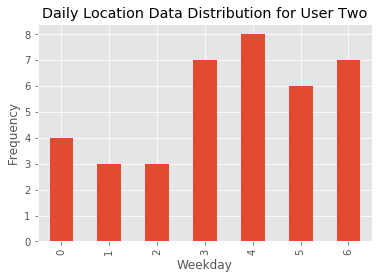

In [108]:
Onedate.groupby(Onedate.index.weekday)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User Two')

Text(0.5,1,'Hourly Location Data Distribution for User Two')

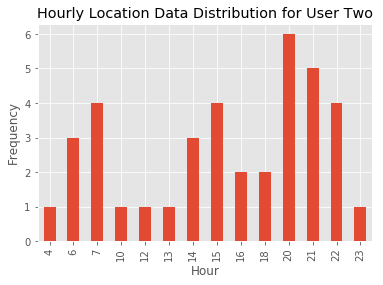

In [109]:

Onedate.groupby(Onedate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User Two')

Text(0.5,1,'Location Activity as Function of Time for User Two')

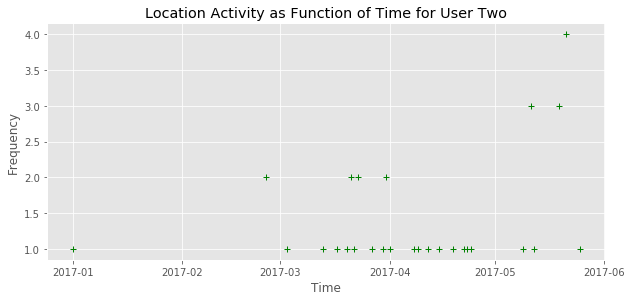

In [110]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Onedate.groupby(Onedate.index.date).size()
plt.plot(top.index, top, 'g+')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User Two')

**Discussion on User Two**

User two lives on Batam Island near Singapore. His most frequently visited location shows activity throughout the day, the week and much of the year and therefore is a good candidate for his home location. His second most frequently visited loction shows activity throught the week and day too but only intermittently throughout the year and is therefore highly unlikely to be his home. In fact google maps shows that the largest clustering is in a poor looking residential area of Batam island while the second biggest clustering is a junction of a busy road not too far from his home. 

## Profile of User Three

Finally we investigate the location data for user three.

In [111]:
ID3 = data[ data['ID'] == '283FCF1B13BC4D9C947AD983621D1EB1']
ID3.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.604250,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.606490,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:19:47+00:00,-6.906105,107.603905,1414,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.605510,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.609440,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [112]:
ID3.tail()

,lat,long,error,time_zone,ID
2017-05-24 16:00:35+00:00,-6.879876,107.591576,1414,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-05-27 04:46:29+00:00,-6.892214,107.605350,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-05-27 05:56:14+00:00,-6.906181,107.607820,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-05-27 06:03:39+00:00,-6.894605,107.602550,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-05-27 10:21:55+00:00,-6.891855,107.605490,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [113]:
ID3.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.604250,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.606490,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:19:47+00:00,-6.906105,107.603905,1414,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.605510,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.609440,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [114]:
ID3.describe()

,lat,long,error
count,885.000000,885.000000,885.000000
mean,-6.884420,107.597643,253.307345
std,0.123214,0.389139,428.099124
min,-8.738699,106.153940,5.000000
25%,-6.895988,107.604904,65.000000
50%,-6.893502,107.606300,165.000000
75%,-6.892060,107.607900,165.000000
max,-6.117221,115.181850,3000.000000


In [115]:
ID3[ID3['error'] > 300].count()

lat          93
long         93
error        93
time_zone    93
ID           93
dtype: int64

In [116]:
ID3 = ID3[ID3['error'] < 300]
ID3.describe()

,lat,long,error
count,792.000000,792.000000,792.000000
mean,-6.888392,107.600179,111.704545
std,0.093214,0.292789,58.599337
min,-8.714790,106.279410,5.000000
25%,-6.895576,107.605297,65.000000
50%,-6.893646,107.606465,138.000000
75%,-6.892176,107.607891,165.000000
max,-6.143725,115.173760,229.000000


Removing data with an error greater than 300 for the location data of user three dramatically shifted both the mean and the variance of the error data!

In [117]:
lat3 = ID3['lat'].values
long3 = ID3['long'].values
error3 = ID3['error'].values
np.shape(lat3)

(792,)

In [118]:
# converting the lat, long and error columns of the dataframe to a numpy matrix

ID3sorted = ID3 
coordinates3 = ID3sorted.as_matrix(columns=[ 'long', 'lat', 'error'])
ID3.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.60425,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.60649,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.60551,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.60944,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:58:18+00:00,-6.906175,107.60775,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [119]:
ID3sorted.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.60425,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.60649,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.60551,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.60944,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:58:18+00:00,-6.906175,107.60775,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3310: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3319: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


longitude range 106.27941 115.17376
latitude range -8.71479 -6.143725
size of data (792,)


C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3236: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\jamil\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:3245: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


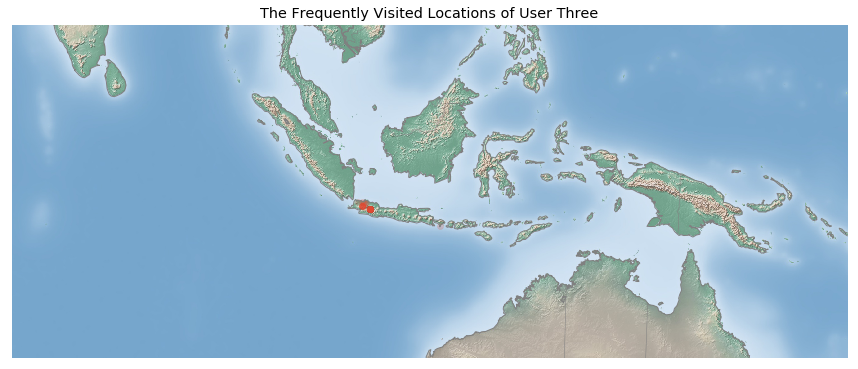

In [120]:
fig = plt.figure(figsize=(15,15))
map = Basemap(projection='lcc', resolution='l',
lat_0=-5, lon_0=114,
width=1E7, height=4E6)
map.shadedrelief()
map.drawcoastlines(color='gray')
map.drawcountries(color='gray')
map.drawstates(color='gray')
plt.title('The Frequently Visited Locations of User Three')

print('longitude range', np.min(long3), np.max(long3))
print('latitude range', np.min(lat3), np.max(lat3))
print('size of data', np.shape(long3))
map.scatter(long3, lat3, latlon=True, alpha=0.2)

Text(0.5,1,'Time Evolution of Location Coordinates of User Three')

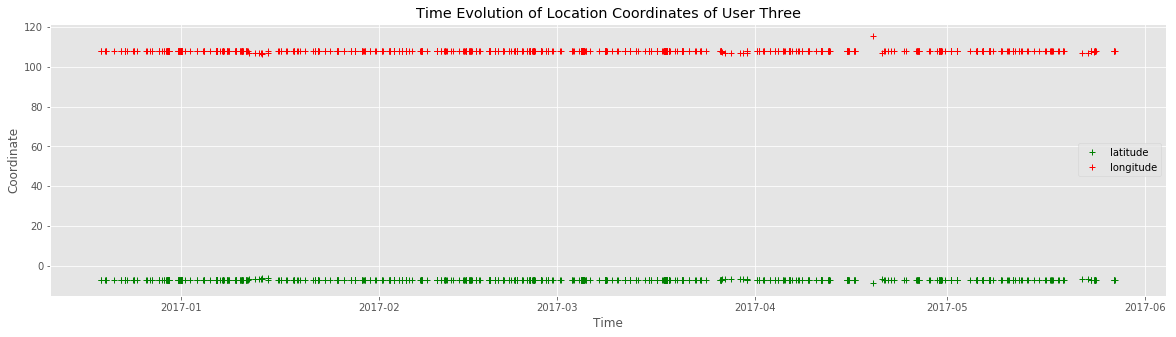

In [121]:
fig = plt.figure(figsize=[20,5])
plt.plot (ID3.index, lat3, 'g+', label = 'latitude')
plt.plot (ID3.index, long3, 'r+', label = 'longitude')
plt.xlabel('Time')
plt.ylabel('Coordinate')
plt.legend()
plt.title('Time Evolution of Location Coordinates of User Three')

Text(0,0.5,'latitude')

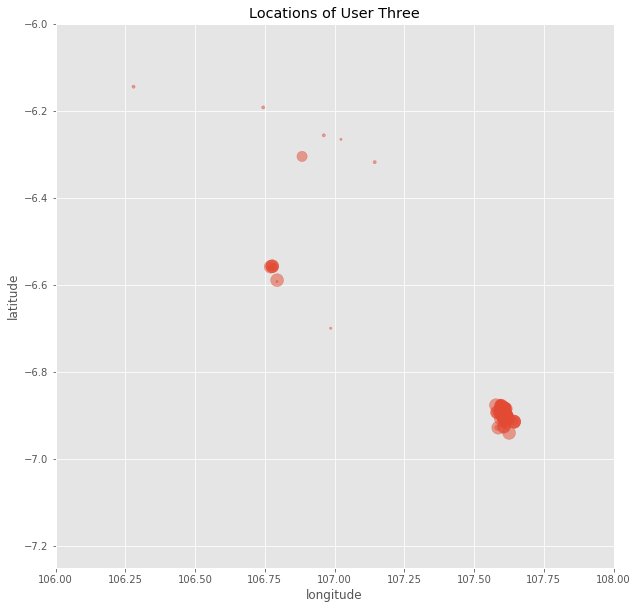

In [122]:

fig = plt.figure(figsize=(10,10))
plt.scatter(long3, lat3, s=error3, alpha = 0.5)
plt.ylim(-7.25,-6.00)
plt.xlim(106,108)
plt.title('Locations of User Three')
#plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('longitude')
plt.ylabel('latitude')

The data shows that this user travels between the city of Bandung and a small town not too far away called Bogor between Bandung and Jakarta.

## DBSCAN Clustering for User Three

In [123]:
coordinates3 = ID3.as_matrix(columns=[ 'long', 'lat', 'error'])

In [124]:
db3 = DBSCAN(eps=0.002, min_samples=6).fit(coordinates3[:,:2])
cluster_labels3 = db3.labels_
unique_labels3 = set(cluster_labels3)

In [125]:
# calculate the number of clusters in labels, ignoring noise (which is labeled -1) if present
num_clusters3 = len(set(cluster_labels3)) - (1 if -1 in cluster_labels3 else 0)
print('The number of clusters found is', num_clusters3)

The number of clusters found is 5


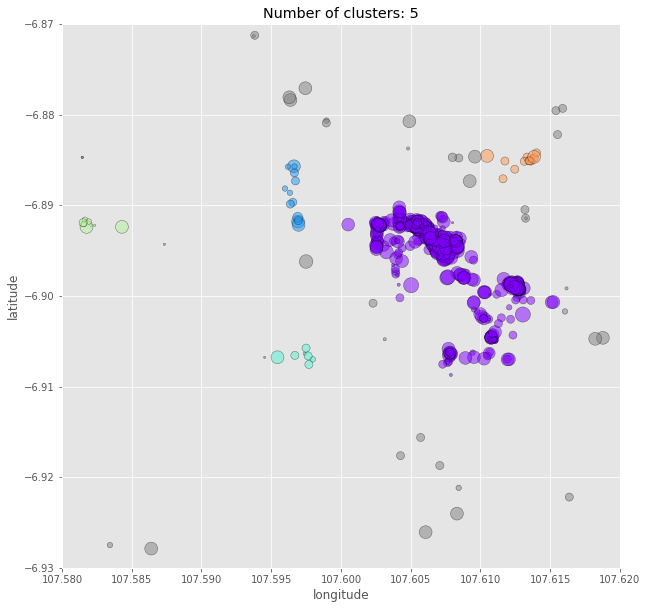

In [126]:
ylims = (-6.93,-6.87)
xlims = (107.58,107.62) 

plot_clusters(coordinates3, unique_labels3, num_clusters3, cluster_labels3, xlims, ylims)

User three's clustering exhibits a much greater dispersal than that of the other two users studied. The body of his main cluster is widely spread out and his other 4 clusters are widely dispersed in area. As the result immediately below shows, his 4 secondary clusters are far below the noise level.  A reasonable conjecture seems to be that he is much more mobile than the other two users. Perhaps he is a taxi driver.

## Analysis of Frequently Visited Locations for User Three

In [127]:
un3 = np.unique(cluster_labels3, return_counts = True)
un3

(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([ 66, 686,  13,   7,   8,  12], dtype=int64))

Note that the noise level for user three is very high.

**Most Active Location of User Three**

In [128]:
zeroInd = cluster_labels3 == 0
Zero = coordinates3[zeroInd]
np.shape(Zero)
Zero = coordinates3[zeroInd]
Zero[:5,:3]

array([[ 107.60425 ,   -6.891508,  165.      ],
       [ 107.60649 ,   -6.893725,  165.      ],
       [ 107.60551 ,   -6.891894,  165.      ],
       [ 107.60944 ,   -6.906251,   30.      ],
       [ 107.60775 ,   -6.906175,   30.      ]])

In [129]:
Zerodate = ID3[zeroInd] # note - used ID3sorted for 1 and 2
Zerodate.head()

,lat,long,error,time_zone,ID
2016-12-19 11:55:12+00:00,-6.891508,107.60425,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 13:45:13+00:00,-6.893725,107.60649,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 04:56:59+00:00,-6.891894,107.60551,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:11:56+00:00,-6.906251,107.60944,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 06:58:18+00:00,-6.906175,107.60775,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


Convert to the local time zone:

In [130]:
Zerodate.index = Zerodate.index.tz_convert('Asia/Jakarta')
Zerodate.head()

,lat,long,error,time_zone,ID
2016-12-19 18:55:12+07:00,-6.891508,107.60425,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-19 20:45:13+07:00,-6.893725,107.60649,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 11:56:59+07:00,-6.891894,107.60551,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 13:11:56+07:00,-6.906251,107.60944,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2016-12-20 13:58:18+07:00,-6.906175,107.60775,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


Text(0.5,1,'Daily Location Data Distribution for User Three')

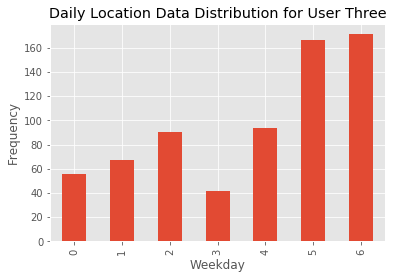

In [131]:
Zerodate.groupby(Zerodate.index.weekday)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User Three')

Text(0.5,1,'Hourly Location Data Distribution for User Three')

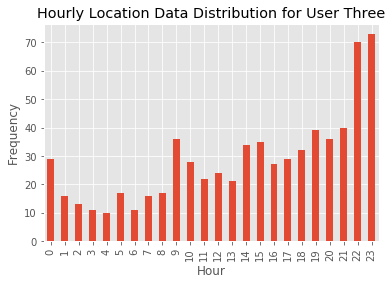

In [132]:
Zerodate.groupby(Zerodate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User Three')

Text(0.5,1,'Location Activity as Function of Time for User Three')

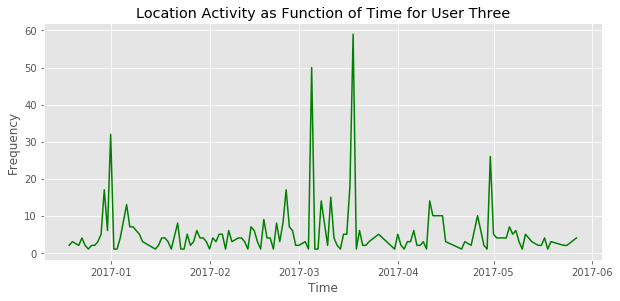

In [133]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Zerodate.groupby(Zerodate.index.date).size()
plt.plot(top.index, top, 'g')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User Three')

**Second Most Active Location of User Three**

In [134]:
oneInd = cluster_labels3 == 1
One = coordinates3[oneInd]
np.shape(One)
One = coordinates3[oneInd]
One[:5,:3]

array([[ 107.59599 ,   -6.888136,   30.      ],
       [ 107.59655 ,   -6.889652,   65.      ],
       [ 107.59637 ,   -6.889857,   65.      ],
       [ 107.596924,   -6.891786,  165.      ],
       [ 107.59696 ,   -6.892146,  165.      ]])

In [135]:
Onedate = ID3[oneInd]
Onedate.head()

,lat,long,error,time_zone,ID
2016-12-27 13:48:26+00:00,-6.888136,107.595990,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-10 12:58:18+00:00,-6.889652,107.596550,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-22 12:59:05+00:00,-6.889857,107.596370,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-25 11:47:47+00:00,-6.891786,107.596924,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-02-03 09:48:19+00:00,-6.892146,107.596960,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [136]:
Onedate = ID3[oneInd]
Onedate.head()

,lat,long,error,time_zone,ID
2016-12-27 13:48:26+00:00,-6.888136,107.595990,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-10 12:58:18+00:00,-6.889652,107.596550,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-22 12:59:05+00:00,-6.889857,107.596370,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-25 11:47:47+00:00,-6.891786,107.596924,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-02-03 09:48:19+00:00,-6.892146,107.596960,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


In [137]:
Onedate.index = Onedate.index.tz_convert('Asia/Jakarta')
Onedate.head()

,lat,long,error,time_zone,ID
2016-12-27 20:48:26+07:00,-6.888136,107.595990,30,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-10 19:58:18+07:00,-6.889652,107.596550,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-22 19:59:05+07:00,-6.889857,107.596370,65,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-01-25 18:47:47+07:00,-6.891786,107.596924,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1
2017-02-03 16:48:19+07:00,-6.892146,107.596960,165,Asia/Jakarta,283FCF1B13BC4D9C947AD983621D1EB1


Text(0.5,1,'Daily Location Data Distribution for User Three')

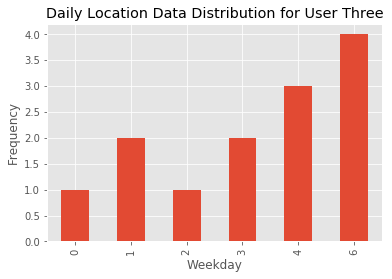

In [138]:
Onedate.groupby(Onedate.index.weekday)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Weekday')
plt.title('Daily Location Data Distribution for User Three')

Text(0.5,1,'Hourly Location Data Distribution for User Three')

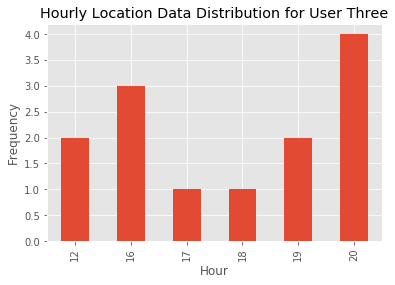

In [139]:
Onedate.groupby(Onedate.index.hour)['lat'].count().plot(kind="bar")
plt.ylabel('Frequency')
plt.xlabel('Hour')
plt.title('Hourly Location Data Distribution for User Three')

Text(0.5,1,'Location Activity as Function of Time for User Three')

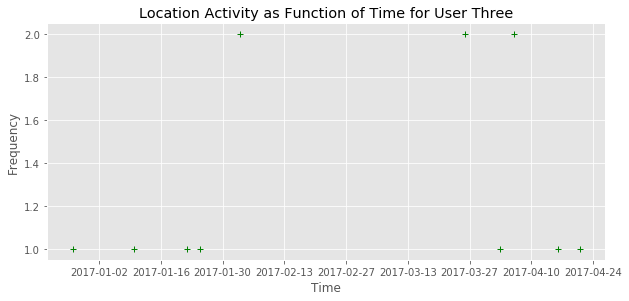

In [140]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 20))
plt.subplot(4, 1, 1)
top = Onedate.groupby(Onedate.index.date).size()
plt.plot(top.index, top, 'g+')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Location Activity as Function of Time for User Three')

**Discussion of Location Data of User Three**

User three's most frequent location shows  activity throughout the day, week and year and is therefore highly likely to be his residence. The second most active location shows irregular activity throughtout the week, day and  the year and is certainly not user three's home. Google maps shows location data of user three's largest cluster is scattered in and around a tower block in Bandung called the Jarrdin. I strongly suspect this is his home.

### Categorization of User's Frequently Visited Locations

In the three user cases studied herein location data coupled with information from google maps provide strong evidence that the most frequently visited location cooincides with the user's home.  Therefore in an automated system the user home can be distinguished from all other locations using the fact that it is highly likely to be the most frequently visited location

The examination of frequently visited location statistics should often also be able to distinguish two very important locations (i.e. home and work) from each other. In the three case studies herein I was not able to seperate home and work locations. However, in many cases it is reasonable to expect that of the two the home is the more frequently visited location.  I further expect to see certain temporal patterns that for most users will distinguish these two locations from each other. Specifically, the home location will show frequent visits during the weekend and, if the mobile is turned on, during the nights of weekends. The work location is unlikely to show visits during weekends for most users and highly unlikely to show visits during weekend nights for any user. Some locations like holiday locations can exhibit the aforementioned home-like temporal visit patterns but they can easily be distinghished from the home location because they will exhibit transient or intermittent visit patterns while home visits will be much more consistent over considerable lengths of time. 

Finally, rather than first clustering in space and then seperately studying the temporal statistics of the clusters, as done here, it might be more useful to combine the spatial and temporal analysis of the data by using spatio-temporal clustering algorithms [2], including a spatio-temporal variant of DBSCAN [3].

# Additional Data of Value

The kind of spatio-temporal mobility data of a service user available in this dataset can aid only to a limited degree in making  inferences about the locations he or she frequently visits. I believe two additional kinds of data, combined with each other, would enhance the ability to correctly make such inferences: personal information about the user and geographic information about the city they inhabit.

The personal profile of an individual such as their age, job, salary, marital status and the number and ages of their children would certainly greatly constrain the areas they would tend to live, work and shop in within any particular city. This information combined with geographical and demographic information about the city such as the location of schools, shopping centres, offices and so on could be used to make strong inferences about their relation to the areas they frequently visit. 

There  may, however, be some potential problems with this kind of information. Many people, particularily in the West, could be reluctant to volunteer a great deal of personal information to a company. Geographic and demographic data is certainly available but to be useable in a machine learning system it must available in easily processed digital form and must also be in an accessible [geographic information systems](https://en.wikipedia.org/wiki/Geographic_information_system). Finally, even if available the data processing needed to make accurate inferences may impose an impractically heavy computational burden.

# Discussion

I summarize my findings in the following sections.

**Location Information from Temporal Statistics**

Studying the temporal statistics of location data gives an indication of the natures of frequently visited locations and therefore allows for their discrimination. A residence for instance is consistently visited over a length of time and on all days of the week and hours of the day. A work place will also be consistently visited but less frequently than a residence and  over more restricted hours and days. Other locations will be visited much less frequently and visitation behaviour will be transient or intermittent. For the purposes of discriminating home from other locations I believe the frequency of visitation will usually be enough - it is reasonable to expect the residence to be more frequently visited than any other location and the residence therefore will correspond to the largest cluster found by the DBSCAN algorithm.

**Dealing with Uncertainties in Location Data**

Some of the location data had enormous values for the uncertainty. The location with very large values of uncertainty I simply removed as they will compromise the integrity of the analysis. The remaining data still exhibited fairly large variations in location uncertainty. In this notebook I treated all the points equally regardless of the value of the uncertainty associated with them. However, a principled analysis would give points with lower uncertainty greater weightage than points with greater uncertainty. One suggestion for dealing with this issue is a version of DBSCAN developed to deal with varying location error [5].

**The Epsilon Parameter**

A meaningful value for the epsilon parameter is crucial in obtaining good clustering. There is, however, no one optimal value for epsilon - it is very much problem and location dependent. The value of epsilon sets the length scale for clustering. A large value will give clustering on the scale of countries, a smaller value on the scale of cities within countries, and a yet smaller value on the scale of locations within a city.

The optimal value of epsilon will depend on the city a user inhabits: clustering length scales will generally be larger in a major city than in a small town. The user's demographic profile will also affect the optimal value of epsilon. A commuter working in a major city will travel more frequently and over larger distances than a student living in student residences in the same city. This will determine the seperation of the clusters they form and hence the value of epsilon that best finds those clusters.

The espilon parameter is also dependent on location because the length a degree of longitude corresponds to is dependent on latitude. This however can be dealt with by converting from units of degrees to lengths.

Finally, the statisics of the uncertainties associated with the locations will influence the value of epsilon. Clearly, if the location data has a mean uncertainty of 5km, for instance, an epsilon value corresponding to a length of 100m is meaningless.

## Conclusion

In this notebook I analysed the dataset of user locations and times.  I used the DBSCAN algorithm to find clusters that correspond to frequently visited locations. I then studied the temporal statistics of these locations in an attempt to infer their categorization, in particular to identify which of these were clusters correspond to the user's home. I concluded the most frequented location has a high probabilty of being the user's home and suggested temporal patterns expected to distinguish the home from the work location. I concluded the notebook with some suggestions for additional information that would be useful in improving inferences about frequently visited locations, and with a summary of my findings.

# Bibliography

1. Pattern Recognation and Machine Learning by Christopher Bishop.
2. Spatial-Temporal Clustering: a Survey by Kisilevich et al.
3. ST-DBSCAN: An algorithm for clustering spatial–temporal data by Birant and Kut. Data and Knowledge Engneering. 2007.
4. Python Data Science Handbook by Jake Vanderplas.
5. Handling Uncertainty and Clustering in Uncertain Data based on KL Divergence Technique by MR and Sahoo.  International Journal of Computer Science and Information Technology & Security. 2013
